In [1]:
from typing import List, Tuple

from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import clone as clone_model

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from stop_words import get_stop_words

np.random.seed = 0

%matplotlib inline

D:\Soft\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Soft\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\Soft\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
twenty_newsgroup = fetch_20newsgroups('./', subset='all')
subj_id_subj_title = dict(zip(range(len(twenty_newsgroup.target_names)), twenty_newsgroup.target_names))
subj_id_subj_title

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

In [3]:
twenty_newsgroup_df = pd.DataFrame()
twenty_newsgroup_df['Text'] = twenty_newsgroup.data
twenty_newsgroup_df['Target'] = twenty_newsgroup.target
twenty_newsgroup_df['Target'] = twenty_newsgroup_df['Target'].replace(subj_id_subj_title)
twenty_newsgroup_df.head()

,Text,Target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,comp.sys.mac.hardware


In [4]:
initial_categories = {
    'rec.sport.baseball': 'sport',
    'rec.sport.hockey': 'sport',
    'talk.politics.guns': 'politics',
    'talk.politics.mideast': 'politics',
    'talk.politics.misc': 'politics',
    'comp.sys.ibm.pc.hardware': 'hardware',
    'comp.sys.mac.hardware': 'hardware',
    'talk.religion.misc': 'religion',
    'rec.motorcycles': 'motorcycles',
    'sci.electronics': 'electronics',
    'comp.graphics': 'graphics'
}

In [5]:
source_cat = ['rec.sport.baseball', 'talk.politics.guns', 'comp.sys.ibm.pc.hardware']
added_cat = ['sci.electronics']

In [6]:
filtered = twenty_newsgroup_df.copy()
filtered = filtered[filtered['Target'].isin(source_cat + added_cat)]
filtered.head()

,Text,Target
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware
5,From: tell@cs.unc.edu (Stephen Tell)\nSubject:...,sci.electronics
16,From: csulo@csv.warwick.ac.uk (Mr M J Brown)\n...,sci.electronics
17,From: schmidt@auvax1.adelphi.edu\nSubject: Re:...,sci.electronics


In [7]:
initial_df = filtered[filtered['Target'].isin(source_cat)]
additional_df = filtered[filtered['Target'].isin(added_cat)]

In [8]:
initial_train, initial_test = train_test_split(initial_df, test_size=0.3, random_state=0)
additional_train, additional_test = train_test_split(additional_df, test_size=0.3, random_state=0)

In [9]:
vectorizer = TfidfVectorizer(
    use_idf=True, 
    min_df=10,
    max_features=100000,
    ngram_range=(1, 3),
    stop_words=get_stop_words('en'),
    norm='l2')
clf = SGDClassifier(loss='modified_huber', alpha=0.0001, penalty='l2', max_iter=500, random_state=0)

initial_pipeline = Pipeline([
        ('vect', vectorizer),
        ('clf', clf)
    ])

initial_pipeline.fit(initial_train['Text'], initial_train['Target'])

print('Classification report:')
print(classification_report(initial_pipeline.predict(initial_test['Text']), initial_test['Target']))

print('\nROC-AUC Score: {}'.format(roc_auc_score(
            initial_test['Target'], 
            initial_pipeline.predict_proba(initial_test['Text']), 
            multi_class='ovo')))

D:\Soft\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Classification report:
                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.99      0.98      0.99       294
      rec.sport.baseball       0.98      0.98      0.98       308
      talk.politics.guns       0.98      0.99      0.98       264

                accuracy                           0.98       866
               macro avg       0.98      0.99      0.99       866
            weighted avg       0.99      0.98      0.98       866


ROC-AUC Score: 0.9994522360572858


In [10]:
def generate_texts(tokens: List[str]) -> List[str]:
    texts = [' '.join(x) for x in np.random.choice(tokens, (2000, 100))]
    return texts

def extend_classifer(new_df: pd.DataFrame, initial_pipline: Pipeline) -> Pipeline:
    initial_vect = initial_pipeline.named_steps['vect']
    initial_model = initial_pipeline.named_steps['clf']
    
    # generating new samples for existing classes from fitted TfidfVectorizer
    generated_texts = generate_texts(initial_vect.get_feature_names())
    
    # Create new SGDClassifier with same as previous parameters
    clf = SGDClassifier(loss='modified_huber', alpha=0.0001, penalty='l2', max_iter=500, random_state=0)
    
    # Create new dataframe with generated texts and new data
    df = pd.DataFrame({'Text': generated_texts, 'Target': ['Other'] * len(generated_texts)})
    new_df = pd.concat([new_df, df])
    
    # Transform new texts with existing fitted vectorizer
    X = initial_vect.transform(new_df['Text'])
    y = new_df['Target']

    clf.fit(X, y)
    
    # Clone initial model
    new_model = clone_model(initial_model)
    
    # Update initial classifier's attributes
    new_model.classes_ = np.append(initial_model.classes_, clf.classes_[1])
    new_model.coef_ = np.append(initial_model.coef_, clf.coef_, axis=0)
    new_model.intercept_ = np.append(initial_model.intercept_, clf.intercept_)
    
    # New pipeline with updated classifier
    return Pipeline([
            ('vect', initial_vect),
            ('clf', new_model)
        ])

In [11]:
p = extend_classifer(additional_train, initial_pipeline)

test = pd.concat([initial_test, additional_test])
print('Classification report:')
print(classification_report(p.predict(test['Text']), test['Target']))

print('\nROC-AUC Score: {}'.format(roc_auc_score(
            test['Target'],
            p.predict_proba(test['Text']),
            multi_class='ovo')))

D:\Soft\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Classification report:
                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.78      0.87      0.82       261
      rec.sport.baseball       0.83      1.00      0.91       258
         sci.electronics       0.88      0.64      0.74       409
      talk.politics.guns       0.88      1.00      0.93       234

                accuracy                           0.84      1162
               macro avg       0.84      0.88      0.85      1162
            weighted avg       0.85      0.84      0.84      1162


ROC-AUC Score: 0.6682616497756867


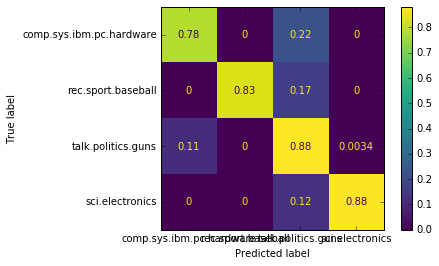

In [12]:
plot_confusion_matrix(
    p, 
    pd.concat([initial_test, additional_test])['Text'], 
    pd.concat([initial_test, additional_test])['Target'], 
    normalize='true')